In [23]:
import numpy as np
import pandas as pd
import IPython
import os
import h5py

from pydub import AudioSegment
from scipy.io import wavfile
from matplotlib import pyplot as plt

%matplotlib inline


In [24]:
background_folder = os.path.join('data', 'background')
negative_folder = os.path.join('data', 'negative')
positive_folder = os.path.join('data', 'positive')

background_filename = os.path.join(background_folder, '42.wav')
negative_filename = os.path.join(negative_folder, '1.wav')
positive_filename = os.path.join(positive_folder, 'rec.wav')

In [25]:
IPython.display.Audio(background_filename)

In [26]:
def draw_spectogram(filename):
    samplingFrequency, signalData = wavfile.read(filename)
    
    dims = signalData.ndim
    
    if dims == 2:
        signalData = signalData[:,0]
    
    plt.subplot(2, 1, 1)
    plt.plot(signalData)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    
    plt.subplot(212)
    pxx, freqs, bins, im = plt.specgram(signalData, Fs=samplingFrequency)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    
    plt.plot()
    return pxx

def draw_spectogram_without_plot(filename):
    samplingFrequency, signalData = wavfile.read(filename)
    
    dims = signalData.ndim
    
    if dims == 2:
        signalData = signalData[:,0]
    
    pxx, freqs, bins, im = plt.specgram(signalData, Fs=samplingFrequency)
    return pxx


def get_random_timesegment(segment):
    start = np.random.randint(low=0, high=10000 - segment)
    end = start + segment - 1
    return (start, end)

def is_overlaping(segment, previous_segments):
    start, end = segment
    is_overlaping = False
    for p_start, p_end in previous_segments:
        if start <= p_end and end >= p_start:
            is_overlaping = True
        
    return is_overlaping

def insert_audio_clip(audio, background, previous_segments):
    
    segment_ms = len(audio)
    
    segment_time = get_random_timesegment(segment_ms)
    
    count = 5
    while is_overlaping(segment_time, previous_segments):
        segment_time = get_random_timesegment(segment_ms)
        
    previous_segments.append(segment_time)
    new_background = background.overlay(audio, position=segment_time[0])
    return new_background, segment_time
    

def insert_ones(y, segment_end_ms, Ty):
    
    segment_end = int(segment_end_ms * Ty/ 10000.0)
    
    for i in range(segment_end, segment_end + 50):
        if i < Ty:
            y[0, i] = 1
    
    return y

def load_audio(dir_name):
    files = []
    for file in os.listdir(dir_name):
        if not file.endswith('wav'):
            continue
        audio = AudioSegment.from_wav(os.path.join(dir_name, file))
        files.append(audio)
    return files

def save_h5(filename, data):  
    with h5py.File(filename, "w") as f:
        f.create_dataset("data", data=data)
        
def load_h5(filename):
    f = h5py.File(filename, 'r')
    return f['data'][:]

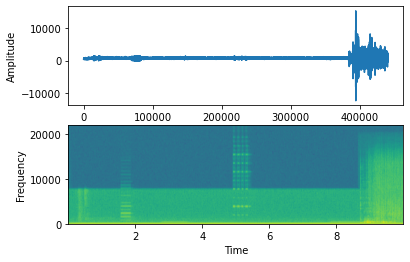

In [27]:
X = draw_spectogram(background_filename)

In [6]:
_, data = wavfile.read(background_filename)
print('Frequency htz',data.shape)
print('After spectogram ',X.shape)

Frequency htz (441000,)
After spectogram  (129, 3444)


In [7]:
Tx = 3444 # timesteps
n_freq = 129
Ty= 860 # (3444 - 8)/4 + 1

In [8]:
def create_training_example(background, positives , negatives):
        
    # quiter background
    background = background - 20
    y = np.zeros((1, Ty))
    
    previous_segments = []
    
    # actives
    num_of_positives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(positives), size=num_of_positives)
    random_positives = [positives[i] for i in random_indices]
    
    for random_positive in random_positives:
        background, segment_time = insert_audio_clip(random_positive, background, previous_segments)
        srg_start, seg_end = segment_time
        y = insert_ones(y, seg_end, Ty)
        
    
    number_of_negatives = np.random.randint(0, 2)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]
    
    
    for random_negative in random_negatives:
        background, _ = insert_audio_clip(random_negative, background, previous_segments)
    
    
    change_in_dBFS =  -20.0 - background.dBFS
    background.apply_gain(change_in_dBFS)
    
    file_handle = background.export("train" + ".wav", format="wav")
    
    X = draw_spectogram_without_plot('train.wav')
    
    return X, y
    

In [9]:
backgrounds = load_audio(background_folder)
positives = load_audio(positive_folder)
negatives = load_audio(negative_folder)

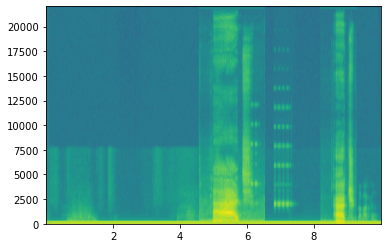

In [13]:
X, y = create_training_example(backgrounds[0], positives , negatives)

In [14]:
IPython.display.Audio('train.wav')


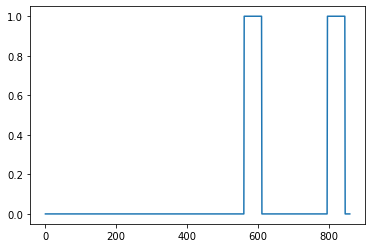

In [15]:
plt.plot(y.T)

In [16]:
dataset_size = 2000

def create_training_dataset():
    X_train = np.zeros((dataset_size, Tx, n_freq))
    y_train = np.zeros((dataset_size, Ty))
    
    
    for i in range(dataset_size):
        background_index = np.random.randint(0, 6)
        print('created ', i)
        X, y = create_training_example(backgrounds[background_index], positives , negatives)
        X_train[i,:,:] = X.T
        y_train[i] = y
        
    return X_train, y_train
        
    
        

created  0
created  1
created  2
created  3
created  4
created  5
created  6
created  7
created  8
created  9
created  10
created  11
created  12
created  13
created  14
created  15
created  16
created  17
created  18
created  19
created  20
created  21
created  22
created  23
created  24
created  25
created  26
created  27
created  28
created  29
created  30
created  31
created  32
created  33
created  34
created  35
created  36
created  37
created  38
created  39
created  40
created  41
created  42
created  43
created  44
created  45
created  46
created  47
created  48
created  49
created  50
created  51
created  52
created  53
created  54
created  55
created  56
created  57
created  58
created  59
created  60
created  61
created  62
created  63
created  64
created  65
created  66
created  67
created  68
created  69
created  70
created  71
created  72
created  73
created  74
created  75
created  76
created  77
created  78
created  79
created  80
created  81
created  82
created  83
cr

created  641
created  642
created  643
created  644
created  645
created  646
created  647
created  648
created  649
created  650
created  651
created  652
created  653
created  654
created  655
created  656
created  657
created  658
created  659
created  660
created  661
created  662
created  663
created  664
created  665
created  666
created  667
created  668
created  669
created  670
created  671
created  672
created  673
created  674
created  675
created  676
created  677
created  678
created  679
created  680
created  681
created  682
created  683
created  684
created  685
created  686
created  687
created  688
created  689
created  690
created  691
created  692
created  693
created  694
created  695
created  696
created  697
created  698
created  699
created  700
created  701
created  702
created  703
created  704
created  705
created  706
created  707
created  708
created  709
created  710
created  711
created  712
created  713
created  714
created  715
created  716
created  717

created  1253
created  1254
created  1255
created  1256
created  1257
created  1258
created  1259
created  1260
created  1261
created  1262
created  1263
created  1264
created  1265
created  1266
created  1267
created  1268
created  1269
created  1270
created  1271
created  1272
created  1273
created  1274
created  1275
created  1276
created  1277
created  1278
created  1279
created  1280
created  1281
created  1282
created  1283
created  1284
created  1285
created  1286
created  1287
created  1288
created  1289
created  1290
created  1291
created  1292
created  1293
created  1294
created  1295
created  1296
created  1297
created  1298
created  1299
created  1300
created  1301
created  1302
created  1303
created  1304
created  1305
created  1306
created  1307
created  1308
created  1309
created  1310
created  1311
created  1312
created  1313
created  1314
created  1315
created  1316
created  1317
created  1318
created  1319
created  1320
created  1321
created  1322
created  1323
create

created  1841
created  1842
created  1843
created  1844
created  1845
created  1846
created  1847
created  1848
created  1849
created  1850
created  1851
created  1852
created  1853
created  1854
created  1855
created  1856
created  1857
created  1858
created  1859
created  1860
created  1861
created  1862
created  1863
created  1864
created  1865
created  1866
created  1867
created  1868
created  1869
created  1870
created  1871
created  1872
created  1873
created  1874
created  1875
created  1876
created  1877
created  1878
created  1879
created  1880
created  1881
created  1882
created  1883
created  1884
created  1885
created  1886
created  1887
created  1888
created  1889
created  1890
created  1891
created  1892
created  1893
created  1894
created  1895
created  1896
created  1897
created  1898
created  1899
created  1900
created  1901
created  1902
created  1903
created  1904
created  1905
created  1906
created  1907
created  1908
created  1909
created  1910
created  1911
create

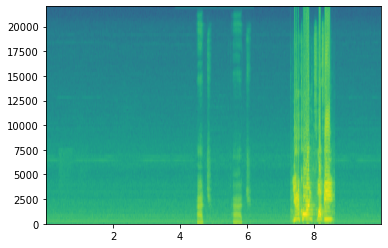

In [17]:
X_train, y_train = create_training_dataset()

In [18]:
save_h5('X_train', X_train)
save_h5('y_train', y_train)

In [19]:
X_train = load_h5('X_train')
y_train = load_h5('y_train')

In [20]:
# y_train = np.expand_dims(y_train, -1)
# print(X_train.shape)
# print(y_train.shape)

X_train = np.array(X_train, dtype='float64')
X_train.dtype

dtype('<f8')

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Conv1D, BatchNormalization, Activation, Dropout, TimeDistributed, Dense

tf.__version__

'2.0.0'

In [22]:
def create_model():
    
    model = Sequential([
        Input(shape=(None, n_freq)),
        Conv1D(filters=196, kernel_size=8, strides=4),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.7),
        
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.7),
        
        LSTM(128, return_sequences=True),
        BatchNormalization(),
        Dropout(0.7),
        
        TimeDistributed(Dense(1, activation='sigmoid'))
    ])
    
    return model
    
    

In [23]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 196)         202468    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 196)         784       
_________________________________________________________________
activation (Activation)      (None, None, 196)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 196)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         166400    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0

In [24]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [25]:
y_train = np.expand_dims(y_train, -1)
model.fit(X_train, y_train, batch_size = 5, epochs=100)
model.save('trained.h5')
model.save_weights('weights.h5')

Train on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 47s 24ms/sample - loss: 0.5380 - accuracy: 0.7801
Epoch 2/100
2000/2000 [==============================] - 37s 19ms/sample - loss: 0.2829 - accuracy: 0.9328
Epoch 3/100
2000/2000 [==============================] - 37s 19ms/sample - loss: 0.2424 - accuracy: 0.9381
Epoch 4/100
2000/2000 [==============================] - 37s 19ms/sample - loss: 0.2157 - accuracy: 0.9392
Epoch 5/100
2000/2000 [==============================] - 37s 19ms/sample - loss: 0.1564 - accuracy: 0.9485
Epoch 6/100
2000/2000 [==============================] - 37s 19ms/sample - loss: 0.1289 - accuracy: 0.9580
Epoch 7/100
2000/2000 [==============================] - 37s 19ms/sample - loss: 0.1144 - accuracy: 0.9634
Epoch 8/100
2000/2000 [==============================] - 39s 19ms/sample - loss: 0.1046 - accuracy: 0.9662
Epoch 9/100
2000/2000 [==============================] - 37s 19ms/sample - loss: 0.0969 - accuracy: 0.9686
Epoch 10/100
20

In [28]:
model = load_model('trained.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 196)         202468    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 196)         784       
_________________________________________________________________
activation (Activation)      (None, None, 196)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 196)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         166400    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128)         512       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0

In [29]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = draw_spectogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [30]:
chime_file = "data/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            # Step 6: Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

C:\Users\prave\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
C:\Users\prave\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


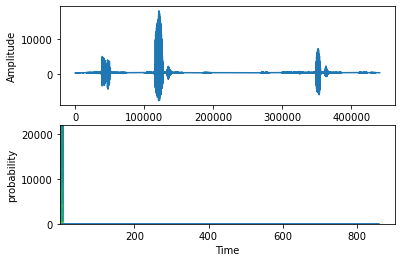

In [31]:
prediction = detect_triggerword("train.wav")
chime_on_activate("train.wav", prediction, 0.5)
IPython.display.Audio("./chime_output.wav")